In [2]:
!nvidia-smi

Fri Dec 23 14:43:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0  On |                  N/A |
| 30%   38C    P8    32W / 350W |   6810MiB / 24245MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np
import pandas as pd
import fasttext

In [5]:
def word_to_id(seq):
    word2id = {}

    for word in seq:
        if word not in word2id:
            word2id[word] = len(word2id)
    return word2id

def get_ids(sentence, word2id):
    ids = []
    for word in sentence:
        if word in word2id:
            ids.append(word2id[word])
        else:
            ids.append(0)
    return torch.tensor(ids, dtype= torch.long)

def get_embeddings(word2id, embedding_dim, embedding_file):
    ft = fasttext.load_model(embedding_file)
    embedding_matrix = np.zeros((len(word2id), embedding_dim))
    
    for word,i in word2id.items():
        embedding_matrix[i] = ft[word]
    return embedding_matrix

In [6]:
class LSTMModel(LightningModule):
    def __init__(self, embedding_matrix, hidden_size, output_size, num_layers=1, bidirectional=False, loss_weights=None):
        super().__init__()

        self.hidden_dim = hidden_size

        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], _weight=torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim, hidden_size,num_layers=num_layers, dropout=0.3, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        
        if bidirectional:
            self.fc1 = nn.Linear(2*hidden_size, 3*hidden_size)
            self.fc2 = nn.Linear(3*hidden_size, output_size)
        else:
            self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
            self.fc2 = nn.Linear(2*hidden_size, output_size)
        
        self.relu = nn.ReLU()

        if loss_weights is None:
            self.loss_function = nn.NLLLoss()
        else:
            self.loss_function = nn.NLLLoss(weight=loss_weights)

        self.lr = 0.01

    def forward(self, input):        
        x = self.embedding(input.unsqueeze(0))
        x, _  = self.lstm(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=2)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_function(y_hat[0], y)
        return loss

In [11]:
df = pd.read_csv('./preprocessed_wikitext/train0-10.csv').dropna()
words_seq = df['words'].to_list()
labels_seq = df['labels'].to_list()
del df

In [55]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]
label2id = {k:i for i, k in enumerate(labels_set)}
id2label = {i:k for i, k in enumerate(labels_set)}

In [13]:
embedding_file = './cc.en.300.bin'
embedding_dim = 300

word2id = word_to_id(words_seq)
embedding_matrix = get_embeddings(word2id, embedding_dim, embedding_file)

In [14]:
word_id_seq = get_ids(words_seq, word2id) #get_idsreturns tensor
del words_seq
label_id_seq = get_ids(labels_seq, label2id)
del labels_seq

In [15]:
count = label_id_seq.unique(return_counts=True)
weights = 1 - count[1] / torch.sum(count[1])

In [17]:
seq_length = 200

train_set = TensorDataset(word_id_seq, label_id_seq)
train_loader = DataLoader(train_set, batch_size=seq_length)

In [18]:
tagger = LSTMModel(embedding_matrix=embedding_matrix,
                   hidden_size=32,
                   output_size=len(labels_set),
                   bidirectional=False,
                   loss_weights = weights
                   )
tagger.float()

/home/mostafa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMModel(
  (embedding): Embedding(136588, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

In [21]:
trainer = pl.Trainer(max_epochs=1,
                     gpus=1,
                     default_root_dir='./blstm_models/0/'
                     )


/home/mostafa/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
tagger.unfreeze()
tagger.train()

LSTMModel(
  (embedding): Embedding(136588, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

In [23]:
trainer.fit(tagger, train_loader)

Missing logger folder: blstm_models/0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      | Params
--------------------------------------------
0 | embedding     | Embedding | 41.0 M
1 | lstm          | LSTM      | 42.8 K
2 | dropout       | Dropout   | 0     
3 | fc1           | Linear    | 2.1 K 
4 | fc2           | Linear    | 455   
5 | relu          | ReLU      | 0     
6 | loss_function | NLLLoss   | 0     
--------------------------------------------
41.0 M    Trainable params
0         Non-trainable params
41.0 M    Total params
164.087   Total estimated model params size (MB)
/home/mostafa/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve p

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [26]:
!nvidia-smi

Fri Dec 23 15:03:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0  On |                  N/A |
| 56%   64C    P2   123W / 350W |   7873MiB / 24245MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
trainer.save_checkpoint('./blstm_models/0/fst.ckpt')

In [28]:
tagger.freeze()
tagger.eval()

LSTMModel(
  (embedding): Embedding(136588, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

In [29]:
df = pd.read_csv('./preprocessed_wikitext/test.csv')
test_words_seq = df['words'].to_list()
test_labels_seq = df['labels'].to_list()
del df

In [30]:
test_word_id_seq = get_ids(test_words_seq, word2id) #get_idsreturns tensor
del test_words_seq
test_label_id_seq = get_ids(test_labels_seq, label2id)
del test_labels_seq

In [31]:
seq_length = 200

test_set = TensorDataset(test_word_id_seq, test_label_id_seq)
test_loader = DataLoader(test_set, batch_size=seq_length)

In [32]:
tagger.cuda()

LSTMModel(
  (embedding): Embedding(136588, 300)
  (lstm): LSTM(300, 32, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (loss_function): NLLLoss()
)

In [33]:
preds= []
for data in test_loader:
    preds.append(tagger(data[0].cuda()))

In [34]:
test_preds = []
for scores in preds:
    scores = scores[0].detach().cpu().numpy()
    scores = scores.argmax(axis=-1)
    for score in scores:
        test_preds.append(score)

In [35]:
true_labels = test_label_id_seq.numpy()

In [58]:
test_preds_label_list = [*map(id2label.get, test_preds)]
true_label_list = [*map(id2label.get, true_labels)]

In [61]:
from sklearn import metrics 
print(metrics.classification_report(true_label_list,test_preds_label_list, target_names=labels_set))

/home/mostafa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     I-COMMA       0.00      0.00      0.00       310
       I-DOT       0.13      0.79      0.23     11091
     I-QMARK       0.00      0.00      0.00      8891
     I-EMARK       0.00      0.00      0.00        20
     I-COLON       0.00      0.00      0.00        12
 I-SEMICOLON       0.00      0.00      0.00       547
           O       0.97      0.74      0.84    194821

    accuracy                           0.71    215692
   macro avg       0.16      0.22      0.15    215692
weighted avg       0.88      0.71      0.77    215692



/home/mostafa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=true_label_list, y_pred=test_preds_label_list, labels=labels_set)
cm

array([[  8717,      0,      0,      0,      0,      0,   2374],
       [  6885,      0,      0,      0,      0,      0,   2006],
       [     9,      0,      0,      0,      0,      0,      3],
       [    16,      0,      0,      0,      0,      0,      4],
       [   182,      0,      0,      0,      0,      0,    128],
       [   416,      0,      0,      0,      0,      0,    131],
       [ 49769,      0,      0,      0,      0,      0, 145052]])

In [65]:
sum = np.sum(cm, axis=1)
sum = np.expand_dims(sum, axis=1)

In [66]:
nor_cm = (cm/sum)
nor_cm

array([[0.78595257, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.21404743],
       [0.77437859, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.22562141],
       [0.75      , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.25      ],
       [0.8       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.2       ],
       [0.58709677, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.41290323],
       [0.76051188, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.23948812],
       [0.25546014, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.74453986]])

In [67]:
nor_cm.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

Text(114.0, 0.5, 'True Label')

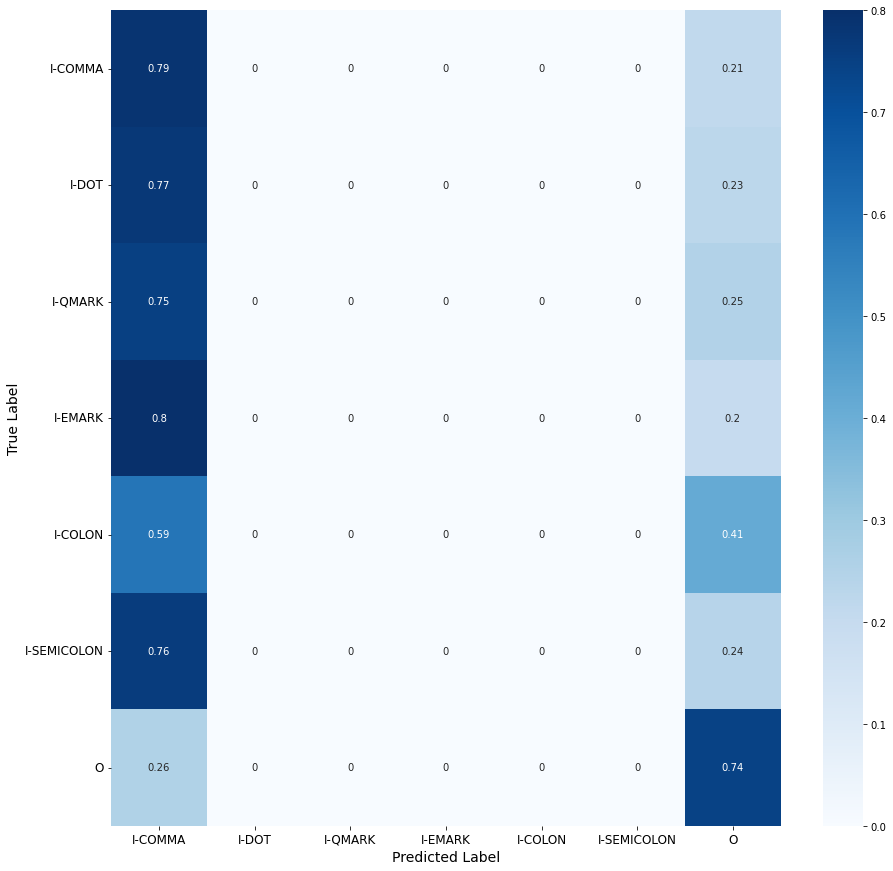

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plot_labels = labels_set

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(nor_cm,
            ax=ax, 
            annot=True,
            cmap='Blues', 
            xticklabels=plot_labels,
            yticklabels=plot_labels)
plt.yticks(rotation=0,size=12)
plt.xticks(size=12)
ax.set_xlabel('Predicted Label',size=14)
ax.set_ylabel('True Label',size=14)